In [1]:
import paddle
import paddle.nn.functional as F
import numpy as np
import pandas as pd
import os
from PIL import Image

IMAGE_SIZE = 224

print(paddle.__version__)

2.4.1


In [8]:
# 定义数据集
class MyDataset(paddle.io.Dataset):
    def __init__(self, img_dir='data/PALM-Training400/', csv_dir='data/Classification.csv') -> None:
        super(MyDataset, self).__init__()
        self.csvfile = pd.read_csv(csv_dir)
        self.imgpath = img_dir
        pass
    def __len__(self):
        return len(self.csvfile)
    def __getitem__(self, idx):
        img = np.reshape((np.array(Image.open(self.imgpath+os.sep+self.csvfile['imgName'][idx]).resize((IMAGE_SIZE,IMAGE_SIZE))).astype('float32')),(3,IMAGE_SIZE,IMAGE_SIZE))/256.
        lab = np.array(self.csvfile['Label'][idx])
        return img,lab
    pass
mydataset = MyDataset()
mydataloader = paddle.io.DataLoader(
    mydataset,
    batch_size=4
)

In [ ]:
class MyNet(paddle.nn.Layer):
    

In [8]:
for x in mydataloader:
    print(x)
    break

[Tensor(shape=[4, 3, 1444, 1444], dtype=float32, place=Place(gpu_pinned), stop_gradient=True,
       [[[[0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          ...,
          [0.34765625, 0.19921875, 0.50781250, ..., 0.10937500,
           0.37890625, 0.21484375],
          [0.12109375, 0.37500000, 0.21093750, ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.33984375,
           0.19531250, 0.50781250]],

         [[0.34375000, 0.19531250, 0.51171875, ..., 0.10937500,
           0.37500000, 0.19921875],
          [0.10937500, 0.37890625, 0.20312500, ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.35937500,
           0.20312500, 0.

Exception in thread Thread-5 (_thread_loop):
Traceback (most recent call last):
  File "/home/zhangzrjerry/anaconda3/envs/globalenv/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/zhangzrjerry/anaconda3/envs/globalenv/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zhangzrjerry/anaconda3/envs/globalenv/lib/python3.10/site-packages/paddle/fluid/dataloader/dataloader_iter.py", line 217, in _thread_loop
    batch = self._dataset_fetcher.fetch(indices,
  File "/home/zhangzrjerry/anaconda3/envs/globalenv/lib/python3.10/site-packages/paddle/fluid/dataloader/fetcher.py", line 125, in fetch
    data.append(self.dataset[idx])
  File "/tmp/ipykernel_437064/1889293168.py", line 11, in __getitem__
  File "<__array_function__ internals>", line 180, in reshape
  File "/home/zhangzrjerry/anaconda3/envs/globalenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py", line 298, in reshape
    return _

In [9]:
np.shape(mydataset[0][0])

(3, 224, 224)

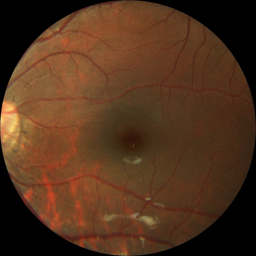

In [7]:
Image.open('data/PALM-Training400/H0001.jpg').resize((256,256))